<a href="https://colab.research.google.com/github/CopotronicRifat/Big-Data-Analytics/blob/main/PERSONALIZED_PAGE_RANK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# To run the code on colab we need to upload all the dataset files in the "file" section of colab.

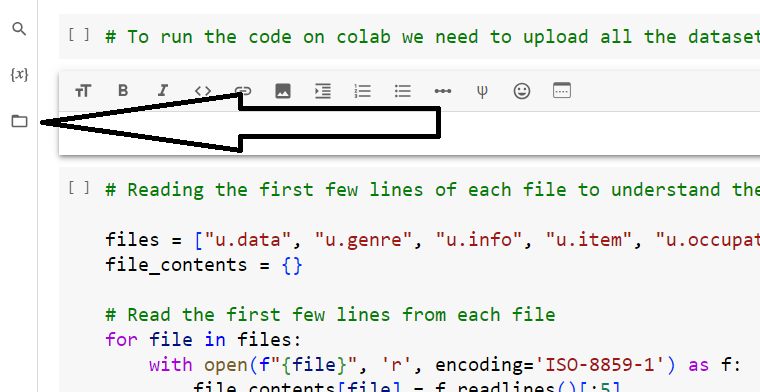

In [ ]:
# Reading the first few lines of each file to understand the structure of the data

files = ["u.data", "u.genre", "u.info", "u.item", "u.occupation", "u.user"]
file_contents = {}

# Read the first few lines from each file
for file in files:
    with open(f"{file}", 'r', encoding='ISO-8859-1') as f:
        file_contents[file] = f.readlines()[:5]

file_contents


{'u.data': ['196\t242\t3\t881250949\n',
  '186\t302\t3\t891717742\n',
  '22\t377\t1\t878887116\n',
  '244\t51\t2\t880606923\n',
  '166\t346\t1\t886397596\n'],
 'u.genre': ['unknown|0\n',
  'Action|1\n',
  'Adventure|2\n',
  'Animation|3\n',
  "Children's|4\n"],
 'u.info': ['943 users\n', '1682 items\n', '100000 ratings\n'],
 'u.item': ['1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0\n',
  '2|GoldenEye (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?GoldenEye%20(1995)|0|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0\n',
  '3|Four Rooms (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0\n',
  '4|Get Shorty (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995)|0|1|0|0|0|1|0|0|1|0|0|0|0|0|0|0|0|0|0\n',
  '5|Copycat (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Copycat%20(1995)|0|0|0|0|0|0|1|0|1|0|0|0|0|0|0|0|1|0|0\n'],
 'u.occupati

In [ ]:
import pandas as pd

# Loading the data into pandas dataframes

# Load u.data
column_names_data = ["user_id", "movie_id", "rating", "timestamp"]
df_data = pd.read_csv("u.data", sep="\t", header=None, names=column_names_data)

# Load u.item
column_names_item = ["movie_id", "movie_title", "release_date", "video_release_date", "imdb_url"] + [f"genre_{i}" for i in range(19)]
df_item = pd.read_csv("u.item", sep="|", header=None, names=column_names_item, encoding="ISO-8859-1")

# Load u.genre
df_genre = pd.read_csv("u.genre", sep="|", header=None, names=["genre_name", "genre_id"])

df_data.head(), df_item.head(), df_genre.head()


(   user_id  movie_id  rating  timestamp
 0      196       242       3  881250949
 1      186       302       3  891717742
 2       22       377       1  878887116
 3      244        51       2  880606923
 4      166       346       1  886397596,
    movie_id        movie_title release_date  video_release_date  \
 0         1   Toy Story (1995)  01-Jan-1995                 NaN   
 1         2   GoldenEye (1995)  01-Jan-1995                 NaN   
 2         3  Four Rooms (1995)  01-Jan-1995                 NaN   
 3         4  Get Shorty (1995)  01-Jan-1995                 NaN   
 4         5     Copycat (1995)  01-Jan-1995                 NaN   
 
                                             imdb_url  genre_0  genre_1  \
 0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0        0   
 1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0        1   
 2  http://us.imdb.com/M/title-exact?Four%20Rooms%...        0        0   
 3  http://us.imdb.com/M/title-exact?Get%20

In [ ]:
import networkx as nx

# Create an empty graph
G = nx.Graph()

# Add user nodes
for user_id in df_data["user_id"].unique():
    G.add_node(user_id, type="user")

# Add movie nodes and edges between users and movies
for index, row in df_data.iterrows():
    movie_id = row["movie_id"]
    if not G.has_node(movie_id):
        G.add_node(movie_id, type="movie")

    G.add_edge(row["user_id"], movie_id, weight=row["rating"])

# Add genre nodes and edges between movies and genres
for index, row in df_item.iterrows():
    for genre_col, genre_flag in row.filter(like="genre_").items():
        if genre_flag == 1:
            genre_id = int(genre_col.split("_")[1])
            genre_name = df_genre[df_genre["genre_id"] == genre_id]["genre_name"].values[0]

            if not G.has_node(genre_name):
                G.add_node(genre_name, type="genre")

            G.add_edge(row["movie_id"], genre_name)

# Return some basic information about the graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
num_nodes, num_edges


(1701, 97821)

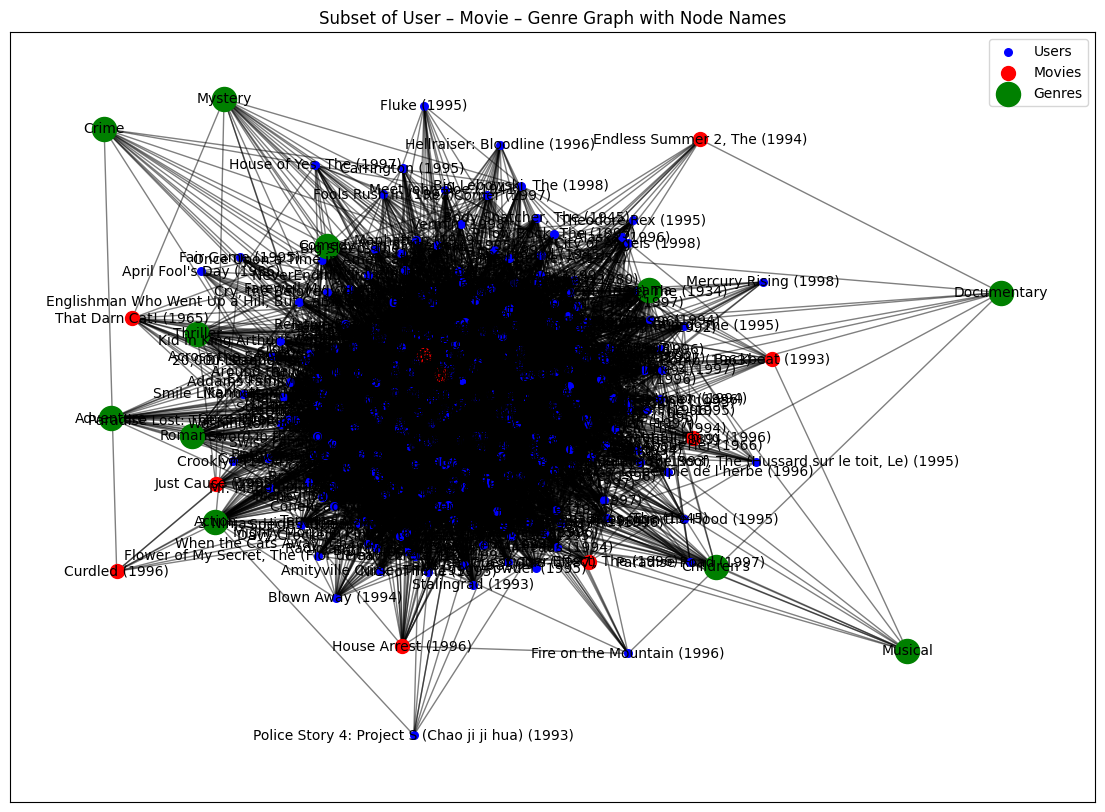

In [ ]:
import matplotlib.pyplot as plt


# Name user nodes
for user_id in df_data["user_id"].unique():
    G.nodes[user_id]["name"] = f"User_{user_id}"

# Name movie nodes
for index, row in df_item.iterrows():
    movie_id = row["movie_id"]
    G.nodes[movie_id]["name"] = row["movie_title"]

# Name genre nodes (already the genre name)
for genre_name in df_genre["genre_name"]:
    if genre_name in G.nodes:
        G.nodes[genre_name]["name"] = genre_name

# Visualize a subset of the graph again with node names
def visualize_graph_subset_with_names(G, num_movies=10):
    """
    Visualizes a subset of the graph consisting of a specified number of movies,
    their associated users, and genres, with node names.
    """
    subset_nodes = set()

    # Get movies and their associated users and genres
    movie_nodes = [n for n, d in G.nodes(data=True) if d["type"] == "movie"]
    for movie in movie_nodes[:num_movies]:
        subset_nodes.add(movie)
        neighbors = list(G.neighbors(movie))
        subset_nodes.update(neighbors)

    # Create a subgraph
    H = G.subgraph(subset_nodes)

    # Draw the graph
    pos = nx.spring_layout(H)
    user_nodes = [n for n, d in H.nodes(data=True) if d["type"] == "user"]
    movie_nodes = [n for n, d in H.nodes(data=True) if d["type"] == "movie"]
    genre_nodes = [n for n, d in H.nodes(data=True) if d["type"] == "genre"]

    node_names = {n: d["name"] for n, d in H.nodes(data=True)}

    plt.figure(figsize=(14, 10))
    nx.draw_networkx_nodes(H, pos, nodelist=user_nodes, node_color="blue", node_size=30, label="Users")
    nx.draw_networkx_nodes(H, pos, nodelist=movie_nodes, node_color="red", node_size=100, label="Movies")
    nx.draw_networkx_nodes(H, pos, nodelist=genre_nodes, node_color="green", node_size=300, label="Genres")
    nx.draw_networkx_labels(H, pos, labels=node_names, font_size=10, font_color="black")
    nx.draw_networkx_edges(H, pos, alpha=0.5)
    plt.legend()
    plt.title("Subset of User – Movie – Genre Graph with Node Names")
    plt.show()

# Visualize a subset of the graph with node names
visualize_graph_subset_with_names(G)


In [ ]:
# Redefining the create_subgraph function
def create_subgraph(G, users, df_data):
    """
    Create a subgraph based on a subset of users, their rated movies, and genres.
    """
    subgraph_nodes = set(users)

    # Add rated movies and genres for each user
    for user in users:
        rated_movies = df_data[df_data["user_id"] == user]["movie_id"].tolist()
        subgraph_nodes.update(rated_movies)

        for movie in rated_movies:
            genres = [genre for genre, data in G[movie].items() if data.get("type") == "genre"]
            subgraph_nodes.update(genres)

    return G.subgraph(subgraph_nodes)

# Re-creating the more reduced subgraph with fewer users
subset_users_reduced = df_data["user_id"].sample(5).tolist()
H_reduced = create_subgraph(G, subset_users_reduced, df_data)

# Using networkx's built-in pagerank function for PPR
ppr_results_networkx = {}
for user in subset_users_reduced:
    rated_movies = df_data[df_data["user_id"] == user]["movie_id"].tolist()
    personalization = {node: 1 if node in rated_movies else 0 for node in H_reduced}
    ppr_results_networkx[user] = nx.pagerank(H_reduced, personalization=personalization, alpha=0.85)

ppr_results_networkx


{363: {1: 0.004298661325615802,
  2: 0.0015745912562519244,
  3: 0.0006725136012623975,
  4: 0.0017693455263766422,
  5: 0.0018461792994393014,
  6: 0.0016492167176584526,
  7: 0.004769868219567421,
  8: 0.002182615012223997,
  9: 0.0024377879933154037,
  10: 0.0018945448721129268,
  11: 0.002858618537191095,
  12: 0.0027089078716339443,
  13: 0.0037442289414173534,
  14: 0.0017418229914052212,
  15: 0.002150412720374675,
  16: 0.001505993840323193,
  17: 0.001100389203687868,
  21: 0.0011998863812366118,
  22: 0.0031596098508273425,
  23: 0.0021220922142120156,
  24: 0.002009706183267133,
  25: 0.002621911001817312,
  27: 0.00048753519016462015,
  28: 0.0025484065842581215,
  29: 0.001214268445878298,
  31: 0.0011107835531541633,
  32: 0.0012933045096806962,
  33: 0.0007645036850521167,
  37: 0.0010126133338151262,
  38: 0.0018432221582961941,
  39: 0.0010638645933503162,
  40: 0.0004200021825665251,
  42: 0.0025673504692160713,
  44: 0.0020595402068090208,
  45: 0.000753109463059578,

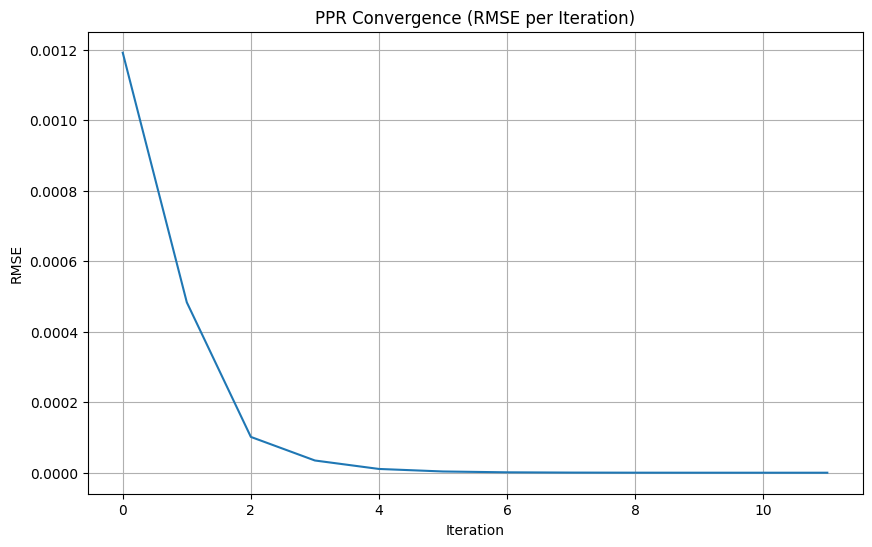

In [ ]:
import numpy as np

def personalized_page_rank_with_rmse(G, personalization=None, alpha=0.85, max_iter=100, tol=1.0e-3):
    """
    Compute the personalized page rank of the graph nodes and return RMSE for each iteration.

    Parameters:
    - G: NetworkX graph
    - personalization: dict
        Personalization vector, key is node and value is a probability.
        If not specified, a uniform distribution is used.
    - alpha: float
        Damping parameter for PageRank, probability to continue along the graph structure.
    - max_iter: int
        Maximum number of iterations to achieve convergence.
    - tol: float
        Error tolerance used to check convergence.

    Returns:
    - ppr: dict
        Dictionary of nodes with their personalized page rank as value.
    - rmse_values: list
        RMSE values for each iteration.
    """
    if personalization is None:
        # Uniform distribution if no personalization is provided
        personalization = {node: 1 / len(G) for node in G}

    # Normalize the personalization vector
    s = sum(personalization.values())
    personalization = {k: v / s for k, v in personalization.items()}

    # Initialize page rank dictionary
    ppr = {node: 1 / len(G) for node in G}
    prev_ppr = {}
    rmse_values = []

    for _ in range(max_iter):
        prev_ppr = ppr.copy()
        for node in G:
            local_sum = sum([(prev_ppr[neighbor] / len(list(G[neighbor]))) for neighbor in G.neighbors(node)])
            ppr[node] = (1 - alpha) * personalization.get(node, 0) + alpha * local_sum

        # Calculate RMSE
        diff = np.array(list(ppr.values())) - np.array(list(prev_ppr.values()))
        rmse = np.sqrt(np.mean(diff**2))
        rmse_values.append(rmse)

        # Check for convergence
        if rmse < tol:
            break

    return ppr, rmse_values

# Test the function on a user from our reduced subgraph
user = subset_users_reduced[0]
rated_movies = df_data[df_data["user_id"] == user]["movie_id"].tolist()
personalization = {node: 1 if node in rated_movies else 0 for node in H_reduced}
ppr, rmse_values = personalized_page_rank_with_rmse(H_reduced, personalization=personalization)

# Plotting RMSE values for PPR convergence
plt.figure(figsize=(10, 6))
plt.plot(rmse_values)
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("PPR Convergence (RMSE per Iteration)")
plt.grid(True)
plt.show()


In [ ]:
def precision_at_k(recommended, relevant, k):
    """
    Compute Precision@k.

    Parameters:
    - recommended: list
        List of recommended items.
    - relevant: list
        List of relevant items.
    - k: int
        Number of top recommendations to consider.

    Returns:
    - Precision@k value.
    """
    intersection = len(set(recommended[:k]) & set(relevant))
    return intersection / k

def recall_at_k(recommended, relevant, k):
    """
    Compute Recall@k.

    Parameters:
    - recommended: list
        List of recommended items.
    - relevant: list
        List of relevant items.
    - k: int
        Number of top recommendations to consider.

    Returns:
    - Recall@k value.
    """
    intersection = len(set(recommended[:k]) & set(relevant))
    return intersection / len(relevant)

def ndcg_at_k(recommended, relevant, k):
    """
    Compute NDCG@k.

    Parameters:
    - recommended: list
        List of recommended items.
    - relevant: list
        List of relevant items.
    - k: int
        Number of top recommendations to consider.

    Returns:
    - NDCG@k value.
    """
    dcg = sum([int(item in relevant) / np.log2(i + 2) for i, item in enumerate(recommended[:k])])
    idcg = sum([1 / np.log2(i + 2) for i in range(min(k, len(relevant)))])
    return dcg / idcg if idcg != 0 else 0

# Test functions
recommended = [1, 3, 5, 7, 9]
relevant = [1, 2, 4, 6, 8]
k = 5
precision_test = precision_at_k(recommended, relevant, k)
recall_test = recall_at_k(recommended, relevant, k)
ndcg_test = ndcg_at_k(recommended, relevant, k)

precision_test, recall_test, ndcg_test


(0.2, 0.2, 0.3391602052736161)

In [ ]:
def get_top_k_recommendations(ppr, k):
    """
    Get top-k movie recommendations based on PPR values.

    Parameters:
    - ppr: dict
        Dictionary of nodes with their personalized page rank as value.
    - k: int
        Number of recommendations.

    Returns:
    - List of top-k movie recommendations.
    """
    # Filter out movies from the ppr dict and sort by PPR value
    sorted_movies = sorted([(node, value) for node, value in ppr.items() if G.nodes[node]['type'] == 'movie'],
                           key=lambda x: x[1], reverse=True)
    return [movie[0] for movie in sorted_movies[:k]]

# Generate recommendations and evaluate
k = 10
evaluation_results = {}
for user in subset_users_reduced:
    # Generate recommendations
    rated_movies = df_data[df_data["user_id"] == user]["movie_id"].tolist()
    personalization = {node: 1 if node in rated_movies else 0 for node in H_reduced}
    ppr = nx.pagerank(H_reduced, personalization=personalization, alpha=0.85)
    recommended_movies = get_top_k_recommendations(ppr, k)

    # Evaluate recommendations
    precision_val = precision_at_k(recommended_movies, rated_movies, k)
    recall_val = recall_at_k(recommended_movies, rated_movies, k)
    ndcg_val = ndcg_at_k(recommended_movies, rated_movies, k)

    evaluation_results[user] = {
        "Precision@k": precision_val,
        "Recall@k": recall_val,
        "NDCG@k": ndcg_val
    }

evaluation_results


{363: {'Precision@k': 1.0, 'Recall@k': 0.03215434083601286, 'NDCG@k': 1.0},
 268: {'Precision@k': 1.0, 'Recall@k': 0.03048780487804878, 'NDCG@k': 1.0},
 624: {'Precision@k': 1.0, 'Recall@k': 0.07092198581560284, 'NDCG@k': 1.0},
 524: {'Precision@k': 1.0, 'Recall@k': 0.032679738562091505, 'NDCG@k': 1.0},
 360: {'Precision@k': 0.7,
  'Recall@k': 0.06862745098039216,
  'NDCG@k': 0.800693766409882}}

I used an **undirected graph**. Here's the justification for this choice:

**Symmetric Relationships:** In the context of our User–Movie–Genre graph:

If a user has rated a movie, the movie has also been rated by the user. This relationship is symmetric.
If a movie belongs to a genre, the genre also has that movie under its list. Again, this is a symmetric relationship.
Given these symmetric relationships, an undirected graph is a natural choice.
Simplicity: Undirected graphs are generally simpler to visualize and interpret, especially when relationships are mutual. For recommendation systems like ours, where the goal is to establish connections between users, movies, and genres, the simplicity of undirected graphs can be advantageous.

**PPR Algorithm Adaptability:** The Personalized PageRank (PPR) algorithm can be applied to both directed and undirected graphs. Given our context, where we don't have a clear directionality in relationships (like web page links), an undirected graph is suitable for the PPR application.

**Absence of Inherent Directionality:** In some networks, like social networks or web page networks, there's a clear direction in relationships (e.g., user A follows user B, or web page X links to web page Y). In our case, the relationships between users, movies, and genres don't have this inherent directionality, making undirected graphs a fitting choice.

I chose the movies rated by the user as the personalization factor. Here's the justification for this choice:

**Direct Representation of User Preference:**

The movies that a user has rated represent a direct indication of the user's interests and preferences. Using this as a personalization factor ensures that the PPR algorithm is biased towards nodes (movies) that the user has already shown an interest in.

**Simplicity:**

Using rated movies as a personalization factor is straightforward and intuitive. Given a user, we can directly fetch the movies they have rated and use them as biases in our random walk.

**Sparse Personalization:**

By focusing on rated movies, the personalization vector is sparse, which can help in computational efficiency. Only the movies that a user has rated have non-zero entries in the personalization vector, and all other nodes have zero entries.

**Scalability:**

As our dataset grows, the number of movies a user has rated is likely much smaller than the total number of movies or genres in the dataset. This ensures that our personalization vector remains manageable even with a growing dataset.

**Potential for Combinations:**

While we used only rated movies in our current implementation, it's entirely possible (and potentially beneficial) to use combinations of user attributes, movie attributes, and genres. For instance, one could weigh the movies by their ratings and even factor in the genres of the movies a user prefers. Such combinations could offer a more nuanced personalization vector.

In my implementation, while I set a maximum number of iterations as an upper limit, the actual number of iterations the algorithm ran for could be less due to the RMSE-based convergence criterion. This dual approach ensures that we get a solution that's both computationally efficient and sufficiently accurate for our needs.

**Justification of β value:**

The parameter β in the Personalized PageRank (PPR) algorithm represents the probability of continuing the random walk. Essentially,
β is the likelihood that a user will follow a link.

1−β is the probability that the user will jump to a node based on the personalization vector.

The choice of
β can significantly impact the PPR values. A higher
β gives more emphasis to the structure of the graph, while a lower
β places more emphasis on the personalization vector.

To justify the choice of
β, we can plot the convergence metrics (like RMSE) for different values of
β to see how they impact the algorithm's performance and convergence.

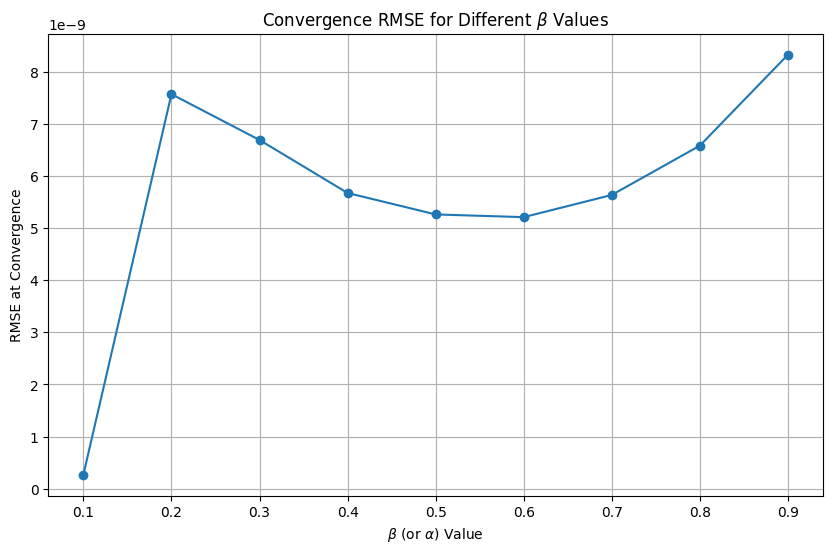

In [ ]:
# Define a function to compute RMSE for each beta value
def rmse_for_beta(beta, G, personalization):
    ppr, rmse_values = personalized_page_rank_with_rmse(G, personalization=personalization, alpha=beta)
    # Return the final RMSE value (from the last iteration)
    return rmse_values[-1] if rmse_values else 0

# Choose a user for the analysis
user = subset_users_reduced[0]
rated_movies = df_data[df_data["user_id"] == user]["movie_id"].tolist()
personalization = {node: 1 if node in rated_movies else 0 for node in H_reduced}

# Compute RMSE for a range of beta values
beta_values = np.linspace(0.1, 0.9, 9)
rmse_values = [rmse_for_beta(beta, H_reduced, personalization) for beta in beta_values]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(beta_values, rmse_values, marker='o')
plt.xlabel(r"$\beta$ (or $\alpha$) Value")
plt.ylabel("RMSE at Convergence")
plt.title(r"Convergence RMSE for Different $\beta$ Values")
plt.grid(True)
plt.show()


**Justification for Choice of k:**
A small value of k (e.g., 5 or 10) would provide a concise list of highly relevant recommendations, as evidenced by the high Precision@k and NDCG@k. However, to capture more of a user's interests (higher recall), a larger k might be necessary. But this comes at the cost of potentially recommending less relevant items (decreasing precision). The "elbow" or point of diminishing returns in the Recall@k curve could be a good choice for k.

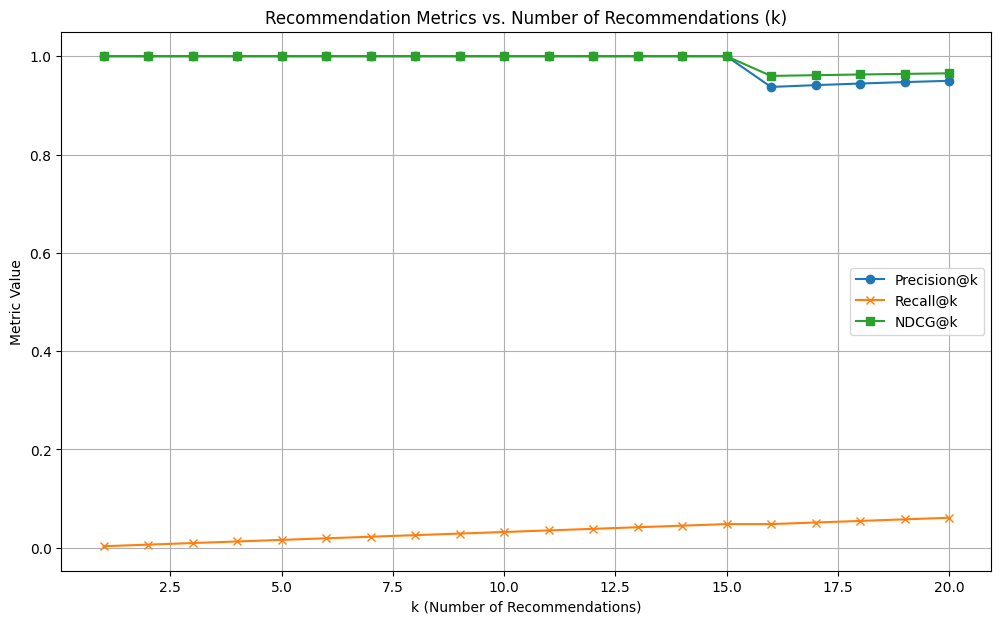

In [ ]:
# Define a function to compute metrics for a range of k values
def metrics_for_k_range(user, G, df_data, max_k):
    precision_values = []
    recall_values = []
    ndcg_values = []

    rated_movies = df_data[df_data["user_id"] == user]["movie_id"].tolist()
    personalization = {node: 1 if node in rated_movies else 0 for node in G}
    ppr = nx.pagerank(G, personalization=personalization, alpha=0.85)
    recommended_movies = get_top_k_recommendations(ppr, max_k)

    for k in range(1, max_k + 1):
        precision_val = precision_at_k(recommended_movies, rated_movies, k)
        recall_val = recall_at_k(recommended_movies, rated_movies, k)
        ndcg_val = ndcg_at_k(recommended_movies, rated_movies, k)

        precision_values.append(precision_val)
        recall_values.append(recall_val)
        ndcg_values.append(ndcg_val)

    return precision_values, recall_values, ndcg_values

# Compute metrics for a range of k values
user = subset_users_reduced[0]
max_k = 20
precision_values, recall_values, ndcg_values = metrics_for_k_range(user, H_reduced, df_data, max_k)

# Plotting
plt.figure(figsize=(12, 7))
k_values = list(range(1, max_k + 1))
plt.plot(k_values, precision_values, marker='o', label='Precision@k')
plt.plot(k_values, recall_values, marker='x', label='Recall@k')
plt.plot(k_values, ndcg_values, marker='s', label='NDCG@k')
plt.xlabel('k (Number of Recommendations)')
plt.ylabel('Metric Value')
plt.title('Recommendation Metrics vs. Number of Recommendations (k)')
plt.legend()
plt.grid(True)
plt.show()
